# Projet

### Imports

In [12]:
# Imports
import glob, os
import pandas
import urllib
from SPARQLWrapper import SPARQLWrapper
import PIL.Image
from skimage import io
import ipywidgets
import matplotlib.pyplot as plt
import numpy
from sklearn.cluster import KMeans
from random import randint
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

### WikiBaseIntegrator Imports

In [13]:
from wikibaseintegrator import WikibaseIntegrator
from wikibaseintegrator.wbi_config import config

config['USER_AGENT'] = 'test'

## 1. Collecte de données

### Dataframe Functions

In [14]:
def getData(): # Lis les données de 'data.json' et les retourne sous forme de dataframe pandas
    path = "data.json"
    with open(path, "r", encoding="utf-8") as f:
        dataframe = pandas.read_json(f, orient='index')
    return dataframe

def saveData(dataframe): # Enregistre une dataframe pandas au format json à 'data.json'
    path = "data.json"
    with open(path, "w", encoding="utf-8") as f:
        f.write(dataframe.to_json(orient='index', indent=2))

def getUsers(): # Lis les données de 'users.json' et les retournes sous forme de dataframe pandas
    path = "users.json"
    with open(path, "r", encoding="utf-8") as f:
        dataframe = pandas.read_json(f, orient='index')
    return dataframe

def saveUsers(dataframe): # Enregistre une dataframe pandas au format json à 'users.json' 
    path = "users.json"
    with open(path, "w", encoding="utf-8") as f:
        f.write(dataframe.to_json(orient='index', indent=2))

### WikiBaseIntegrator Functions

In [15]:
wbi = WikibaseIntegrator()

def GetCountryLabelInFrench(itemID): #Permet de récupérer le label du pays en français à partir de son qualifier/ID WikiData
    item_data=wbi.item.get(itemID) #Récupère les données du monument
    country_id=item_data.claims.get('P17')[0].mainsnak.datavalue['value']['id'] #Récupère l'ID du pays
    country=wbi.item.get(country_id) #Récupère les données du pays
    return country.labels.get('fr').value #Retourne le label du pays en français

def AddCountryTags(dataframe): #Permet d'ajouter le tag du pays à chaque ligne du dataframe
    items_tuples=[]
    for i in range(len(dataframe.index)): # Récupère les IDs de toutes les lignes du dataframe
        itemID=dataframe._get_value(i,"entityID")
        items_tuples.append(itemID)
    for i in range(len(items_tuples)): # Ajoute le pays à chaque ligne du dataframe
        country = GetCountryLabelInFrench(items_tuples[i])
        dataframe.at[i, "tags"].append("#"+country)
    return dataframe

def GetArchitecturalStyle(styleID): #Permet de récupérer le nom du style architectural en français à partir de son qualifier/ID WikiData
    styleL=[]
    for i in range(len(styleID)): # Récupère les IDs de style architectural pour chaque ligne du dataframe
        style = wbi.item.get(styleID[i]) #Récupère les données du style architectural
        if style.labels.get('fr') is None: #Prise en charge du cas où le style n'a pas de nom en français
            style_name = style.labels.get('en').value
        else:
            style_name = style.labels.get('fr').value
        styleL.append("#"+style_name) #Ajoute le nom du style à la liste de résultat
    return styleL #Retourne le nom du style architectural

def AddStyleTags(dataframe): #Permet d'ajouter les tags des styles architecturaux à chaque ligne du dataframe
    for k in range(len(dataframe.index)): #On parcourt chaque ligne du dataframe
        style = GetArchitecturalStyle(dataframe._get_value(k,"style"))
        for l in range(len(style)): #On parcourt chaque indice de la liste de style (un monument peut avoir plusieurs styles)
            dataframe.at[k, "tags"].append(style[l])
    return dataframe

### Récupération du résultat d'une query Wikidata

In [16]:
size = 100
imagesPath = "./images/"

# Query de Wikidata
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
query = """
SELECT ?item ?itemLabel ?pic (YEAR(?date) as ?year) ?style WHERE {
  ?item wdt:P31 wd:Q4989906;
    wdt:P18 ?pic;
    wdt:P571 ?date;
    wdt:P149 ?style.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
LIMIT """
# On précise le nombre d'entrées que l'on veut
query = query + str(size)

# On récupère le résultat de la query
sparql.setQuery(query)
sparql.setReturnFormat("json")
results = sparql.query().convert()
print(results)

# On normalise les résultats pour pandas
array = []
for trainData in results["results"]["bindings"]:
    name = trainData["itemLabel"]["value"]
    format = trainData["pic"]["value"].split(".")[-1]
    path = f"{imagesPath}{name}.{format}"
    if "year" in trainData.keys():
        year = trainData["year"]["value"]
    else:
        year = None
    style = trainData["style"]["value"]
    array.append([name,  
                  trainData["pic"]["value"], 
                  trainData["item"]["value"].split(sep='/')[-1],
                  format,
                  path,
                  (),
                  None,
                  ['#monument'],
                  year,
                  style.split(sep='/')[-1]])
                  

dataframe = pandas.DataFrame(array, columns=["label", "link", "entityID", "format", "path", "size", "sizeCategory", "tags", "year","style"])

#On fusionne les lignes avec le même label en gardant les différents styles
dataframe = dataframe.groupby('label').agg({'link':'first', 'entityID':'first', 'format':'first', 'path':'first', 'size':'first', 'sizeCategory':'first','tags':'first', 'year':'first', 'style':list}).reset_index()

# On enregistre les données au format JSON
saveData(dataframe)

# création du dossier /images si manquant
if not os.path.isdir('./images'):
  os.mkdir('./images')

# Nettoyage du dossier /images
else:
  files = glob.glob('./images/*')
  for f in files:
      os.remove(f)

dataframe

{'head': {'vars': ['item', 'itemLabel', 'pic', 'year', 'style']}, 'results': {'bindings': [{'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q1139113'}, 'style': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q46261'}, 'pic': {'type': 'uri', 'value': 'http://commons.wikimedia.org/wiki/Special:FilePath/Estibalizko%20santutegi%20erromanikoa.jpg'}, 'itemLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Sanctuary of Nuestra Señora de Estíbaliz'}}, {'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q1064212'}, 'style': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q4692'}, 'pic': {'type': 'uri', 'value': 'http://commons.wikimedia.org/wiki/Special:FilePath/SevillaPalacioDeLebrija01.JPG'}, 'itemLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Palacio de la Condesa de Lebrija'}, 'year': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '1600'}}, {'item': {'type': 'uri', 'value': 'http://www.wiki

,label,link,entityID,format,path,size,sizeCategory,tags,year,style
0,"Adam Mickiewicz Monument, Warsaw",http://commons.wikimedia.org/wiki/Special:File...,Q348386,JPG,"./images/Adam Mickiewicz Monument, Warsaw.JPG",(),None,[#monument],1898,"[Q54111, Q54111]"
1,Antiguo Hospital de Nuestra Señora del Carmen,http://commons.wikimedia.org/wiki/Special:File...,Q5903055,JPG,./images/Antiguo Hospital de Nuestra Señora de...,(),None,[#monument],1749,[Q840829]
2,Antiguo Monasterio de San Isidoro del Campo,http://commons.wikimedia.org/wiki/Special:File...,Q778571,jpg,./images/Antiguo Monasterio de San Isidoro del...,(),None,[#monument],1301,[Q15011985]
3,Anıtkabir,http://commons.wikimedia.org/wiki/Special:File...,Q615404,jpg,./images/Anıtkabir.jpg,(),None,[#monument],1953,[Q6101949]
4,Basilica of Candelaria,http://commons.wikimedia.org/wiki/Special:File...,Q34485,jpg,./images/Basilica of Candelaria.jpg,(),None,[#monument],1959,[Q54111]
...,...,...,...,...,...,...,...,...,...,...
69,Vinaròs Church of the Assumption,http://commons.wikimedia.org/wiki/Special:File...,Q946105,jpg,./images/Vinaròs Church of the Assumption.jpg,(),None,[#monument],1600,"[Q236122, Q21032839]"
70,Wallace Monument,http://commons.wikimedia.org/wiki/Special:File...,Q931796,jpg,./images/Wallace Monument.jpg,(),None,[#monument],1869,[Q3476363]
71,Worker and Kolkhoz Woman,http://commons.wikimedia.org/wiki/Special:File...,Q627114,jpg,./images/Worker and Kolkhoz Woman.jpg,(),None,[#monument],1937,"[Q207103, Q12130002]"
72,Yuste,http://commons.wikimedia.org/wiki/Special:File...,Q936453,jpg,./images/Yuste.jpg,(),None,[#monument],1402,[Q867769]


### Téléchargement des Images

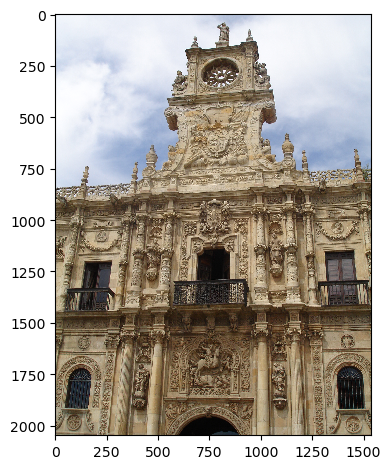

In [17]:
dataframe = getData()
for i in range(len(dataframe.index)):
    # On télécharge l'image
    link = dataframe._get_value(i,"link")
    path = dataframe._get_value(i,"path")
    response = urllib.request.urlretrieve(link, path)


 
img = io.imread(path)
io.imshow(img)

### Récupération des Données EXIFS

In [18]:
dataframe = getData()

# les tags Exifs qui nous intéressent associés aux futurs noms de colonnes pour la dataframe
wantedExifs = [274, 315, 306, 272]
columnNames = ["orientation", "artist", "dateTaken", 'appareil']

# Création des colonnes (pour l'instant vides)
for i,tag in enumerate(wantedExifs):
    dataframe[columnNames[i]] = None
    

# On parcourt les entrées
for i in range(len(dataframe.index)):
    path = dataframe._get_value(i,"path")
    # On récupère les données exif de l'image
    img = PIL.Image.open(path)
    exif_data = img._getexif()
    img.close()

    # On détermine l'orientation de l'image selon sa taille en pixel
    dataframe.at[i, "size"] = img.size
    if img.size[0] < img.size[1]:
        dataframe.at[i, "orientation"] = 0
    else:
        dataframe.at[i, "orientation"] = 1

    # Si les données voulues existent, on les enregistre dans la dataframe
    if exif_data:
      for tag in exif_data:
            if tag in wantedExifs:
                dataframe.at[i, columnNames[wantedExifs.index(tag)]] = exif_data[tag]
                
dataframe.astype({'orientation': 'int32'})

# On enregistre les données au format JSON
saveData(dataframe)
        
dataframe 


,label,link,entityID,format,path,size,sizeCategory,tags,year,style,orientation,artist,dateTaken,appareil
0,"Adam Mickiewicz Monument, Warsaw",http://commons.wikimedia.org/wiki/Special:File...,Q348386,JPG,"./images/Adam Mickiewicz Monument, Warsaw.JPG","(3456, 2592)",NaN,[#monument],1898.0,"[Q54111, Q54111]",1,None,2013:08:29 17:38:59,DSC-H50
1,Antiguo Hospital de Nuestra Señora del Carmen,http://commons.wikimedia.org/wiki/Special:File...,Q5903055,JPG,./images/Antiguo Hospital de Nuestra Señora de...,"(1024, 685)",NaN,[#monument],1749.0,[Q840829],1,None,2013:01:09 03:21:05,NIKON D3000
2,Antiguo Monasterio de San Isidoro del Campo,http://commons.wikimedia.org/wiki/Special:File...,Q778571,jpg,./images/Antiguo Monasterio de San Isidoro del...,"(4608, 3456)",NaN,[#monument],1301.0,[Q15011985],1,None,2013:05:01 13:30:32,Canon PowerShot A2300
3,Anıtkabir,http://commons.wikimedia.org/wiki/Special:File...,Q615404,jpg,./images/Anıtkabir.jpg,"(7594, 3797)",NaN,[#monument],1953.0,[Q6101949],1,A.Savin,2022:01:24 22:43:14,ILCE-7RM3
4,Basilica of Candelaria,http://commons.wikimedia.org/wiki/Special:File...,Q34485,jpg,./images/Basilica of Candelaria.jpg,"(2307, 1689)",NaN,[#monument],1959.0,[Q54111],1,None,2012:05:05 19:07:51,DMC-G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Vinaròs Church of the Assumption,http://commons.wikimedia.org/wiki/Special:File...,Q946105,jpg,./images/Vinaròs Church of the Assumption.jpg,"(2304, 3072)",NaN,[#monument],1600.0,"[Q236122, Q21032839]",0,None,2009:05:02 19:42:55,Canon DIGITAL IXUS 70
70,Wallace Monument,http://commons.wikimedia.org/wiki/Special:File...,Q931796,jpg,./images/Wallace Monument.jpg,"(2288, 1712)",NaN,[#monument],1869.0,[Q3476363],1,None,2010:05:04 11:14:10,C750UZ
71,Worker and Kolkhoz Woman,http://commons.wikimedia.org/wiki/Special:File...,Q627114,jpg,./images/Worker and Kolkhoz Woman.jpg,"(1134, 1294)",NaN,[#monument],1937.0,"[Q207103, Q12130002]",0,None,None,None
72,Yuste,http://commons.wikimedia.org/wiki/Special:File...,Q936453,jpg,./images/Yuste.jpg,"(4032, 2268)",NaN,[#monument],1402.0,[Q867769],1,None,2019:04:14 11:25:20,Mi MIX 2S


## 2. Annotation des images

### Fonction pour récupérer et ajouter le tag siècle

In [19]:
def find_century(year): #Permet de trouver le siècle à partir de l'année
    year = int(year)
    if (year <= 0): 
        cent_tag=("#Antiquité")
    elif (year <= 100):
        cent_tag ="#1er siècle"
    elif (year % 100 == 0):
        cent_tag="#"+str(year // 100)+"ème siècle"
    else:
        cent_tag="#"+str(year // 100 + 1)+"ème siècle"
    return cent_tag

def add_century_tag(dataframe): #Permet d'ajouter le tag siècle à chaque ligne du dataframe
    for i in range(len(dataframe.index)):
        year = dataframe._get_value(i,"year")
        if year is not None and str(year) != 'nan': #Prise en charge du cas où le monument n'a pas de date précise de construction
            dataframe.at[i, "tags"].append(find_century(year))
        else:
            dataframe.at[i, "tags"].append("#Inconnu")
    return dataframe

### Test Ajout du tag siècle

In [20]:
saveData(add_century_tag(dataframe))
getData()

,label,link,entityID,format,path,size,sizeCategory,tags,year,style,orientation,artist,dateTaken,appareil
0,"Adam Mickiewicz Monument, Warsaw",http://commons.wikimedia.org/wiki/Special:File...,Q348386,JPG,"./images/Adam Mickiewicz Monument, Warsaw.JPG","[3456, 2592]",NaN,"[#monument, #19ème siècle]",1898.0,"[Q54111, Q54111]",1,None,2013:08:29 17:38:59,DSC-H50
1,Antiguo Hospital de Nuestra Señora del Carmen,http://commons.wikimedia.org/wiki/Special:File...,Q5903055,JPG,./images/Antiguo Hospital de Nuestra Señora de...,"[1024, 685]",NaN,"[#monument, #18ème siècle]",1749.0,[Q840829],1,None,2013:01:09 03:21:05,NIKON D3000
2,Antiguo Monasterio de San Isidoro del Campo,http://commons.wikimedia.org/wiki/Special:File...,Q778571,jpg,./images/Antiguo Monasterio de San Isidoro del...,"[4608, 3456]",NaN,"[#monument, #14ème siècle]",1301.0,[Q15011985],1,None,2013:05:01 13:30:32,Canon PowerShot A2300
3,Anıtkabir,http://commons.wikimedia.org/wiki/Special:File...,Q615404,jpg,./images/Anıtkabir.jpg,"[7594, 3797]",NaN,"[#monument, #20ème siècle]",1953.0,[Q6101949],1,A.Savin,2022:01:24 22:43:14,ILCE-7RM3
4,Basilica of Candelaria,http://commons.wikimedia.org/wiki/Special:File...,Q34485,jpg,./images/Basilica of Candelaria.jpg,"[2307, 1689]",NaN,"[#monument, #20ème siècle]",1959.0,[Q54111],1,None,2012:05:05 19:07:51,DMC-G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Vinaròs Church of the Assumption,http://commons.wikimedia.org/wiki/Special:File...,Q946105,jpg,./images/Vinaròs Church of the Assumption.jpg,"[2304, 3072]",NaN,"[#monument, #16ème siècle]",1600.0,"[Q236122, Q21032839]",0,None,2009:05:02 19:42:55,Canon DIGITAL IXUS 70
70,Wallace Monument,http://commons.wikimedia.org/wiki/Special:File...,Q931796,jpg,./images/Wallace Monument.jpg,"[2288, 1712]",NaN,"[#monument, #19ème siècle]",1869.0,[Q3476363],1,None,2010:05:04 11:14:10,C750UZ
71,Worker and Kolkhoz Woman,http://commons.wikimedia.org/wiki/Special:File...,Q627114,jpg,./images/Worker and Kolkhoz Woman.jpg,"[1134, 1294]",NaN,"[#monument, #20ème siècle]",1937.0,"[Q207103, Q12130002]",0,None,None,None
72,Yuste,http://commons.wikimedia.org/wiki/Special:File...,Q936453,jpg,./images/Yuste.jpg,"[4032, 2268]",NaN,"[#monument, #15ème siècle]",1402.0,[Q867769],1,None,2019:04:14 11:25:20,Mi MIX 2S


### Test Ajout des tags country et style

In [21]:
saveData(AddCountryTags(dataframe))
getData()

,label,link,entityID,format,path,size,sizeCategory,tags,year,style,orientation,artist,dateTaken,appareil
0,"Adam Mickiewicz Monument, Warsaw",http://commons.wikimedia.org/wiki/Special:File...,Q348386,JPG,"./images/Adam Mickiewicz Monument, Warsaw.JPG","[3456, 2592]",NaN,"[#monument, #19ème siècle, #Pologne]",1898.0,"[Q54111, Q54111]",1,None,2013:08:29 17:38:59,DSC-H50
1,Antiguo Hospital de Nuestra Señora del Carmen,http://commons.wikimedia.org/wiki/Special:File...,Q5903055,JPG,./images/Antiguo Hospital de Nuestra Señora de...,"[1024, 685]",NaN,"[#monument, #18ème siècle, #Espagne]",1749.0,[Q840829],1,None,2013:01:09 03:21:05,NIKON D3000
2,Antiguo Monasterio de San Isidoro del Campo,http://commons.wikimedia.org/wiki/Special:File...,Q778571,jpg,./images/Antiguo Monasterio de San Isidoro del...,"[4608, 3456]",NaN,"[#monument, #14ème siècle, #Espagne]",1301.0,[Q15011985],1,None,2013:05:01 13:30:32,Canon PowerShot A2300
3,Anıtkabir,http://commons.wikimedia.org/wiki/Special:File...,Q615404,jpg,./images/Anıtkabir.jpg,"[7594, 3797]",NaN,"[#monument, #20ème siècle, #Turquie]",1953.0,[Q6101949],1,A.Savin,2022:01:24 22:43:14,ILCE-7RM3
4,Basilica of Candelaria,http://commons.wikimedia.org/wiki/Special:File...,Q34485,jpg,./images/Basilica of Candelaria.jpg,"[2307, 1689]",NaN,"[#monument, #20ème siècle, #Espagne]",1959.0,[Q54111],1,None,2012:05:05 19:07:51,DMC-G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Vinaròs Church of the Assumption,http://commons.wikimedia.org/wiki/Special:File...,Q946105,jpg,./images/Vinaròs Church of the Assumption.jpg,"[2304, 3072]",NaN,"[#monument, #16ème siècle, #Espagne]",1600.0,"[Q236122, Q21032839]",0,None,2009:05:02 19:42:55,Canon DIGITAL IXUS 70
70,Wallace Monument,http://commons.wikimedia.org/wiki/Special:File...,Q931796,jpg,./images/Wallace Monument.jpg,"[2288, 1712]",NaN,"[#monument, #19ème siècle, #Royaume-Uni]",1869.0,[Q3476363],1,None,2010:05:04 11:14:10,C750UZ
71,Worker and Kolkhoz Woman,http://commons.wikimedia.org/wiki/Special:File...,Q627114,jpg,./images/Worker and Kolkhoz Woman.jpg,"[1134, 1294]",NaN,"[#monument, #20ème siècle, #Russie]",1937.0,"[Q207103, Q12130002]",0,None,None,None
72,Yuste,http://commons.wikimedia.org/wiki/Special:File...,Q936453,jpg,./images/Yuste.jpg,"[4032, 2268]",NaN,"[#monument, #15ème siècle, #Espagne]",1402.0,[Q867769],1,None,2019:04:14 11:25:20,Mi MIX 2S


In [22]:
saveData(AddStyleTags(dataframe))
getData()

,label,link,entityID,format,path,size,sizeCategory,tags,year,style,orientation,artist,dateTaken,appareil
0,"Adam Mickiewicz Monument, Warsaw",http://commons.wikimedia.org/wiki/Special:File...,Q348386,JPG,"./images/Adam Mickiewicz Monument, Warsaw.JPG","[3456, 2592]",NaN,"[#monument, #19ème siècle, #Pologne, #architec...",1898.0,"[Q54111, Q54111]",1,None,2013:08:29 17:38:59,DSC-H50
1,Antiguo Hospital de Nuestra Señora del Carmen,http://commons.wikimedia.org/wiki/Special:File...,Q5903055,JPG,./images/Antiguo Hospital de Nuestra Señora de...,"[1024, 685]",NaN,"[#monument, #18ème siècle, #Espagne, #architec...",1749.0,[Q840829],1,None,2013:01:09 03:21:05,NIKON D3000
2,Antiguo Monasterio de San Isidoro del Campo,http://commons.wikimedia.org/wiki/Special:File...,Q778571,jpg,./images/Antiguo Monasterio de San Isidoro del...,"[4608, 3456]",NaN,"[#monument, #14ème siècle, #Espagne, #art mudé...",1301.0,[Q15011985],1,None,2013:05:01 13:30:32,Canon PowerShot A2300
3,Anıtkabir,http://commons.wikimedia.org/wiki/Special:File...,Q615404,jpg,./images/Anıtkabir.jpg,"[7594, 3797]",NaN,"[#monument, #20ème siècle, #Turquie, #Second n...",1953.0,[Q6101949],1,A.Savin,2022:01:24 22:43:14,ILCE-7RM3
4,Basilica of Candelaria,http://commons.wikimedia.org/wiki/Special:File...,Q34485,jpg,./images/Basilica of Candelaria.jpg,"[2307, 1689]",NaN,"[#monument, #20ème siècle, #Espagne, #architec...",1959.0,[Q54111],1,None,2012:05:05 19:07:51,DMC-G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Vinaròs Church of the Assumption,http://commons.wikimedia.org/wiki/Special:File...,Q946105,jpg,./images/Vinaròs Church of the Assumption.jpg,"[2304, 3072]",NaN,"[#monument, #16ème siècle, #Espagne, #architec...",1600.0,"[Q236122, Q21032839]",0,None,2009:05:02 19:42:55,Canon DIGITAL IXUS 70
70,Wallace Monument,http://commons.wikimedia.org/wiki/Special:File...,Q931796,jpg,./images/Wallace Monument.jpg,"[2288, 1712]",NaN,"[#monument, #19ème siècle, #Royaume-Uni, #Scot...",1869.0,[Q3476363],1,None,2010:05:04 11:14:10,C750UZ
71,Worker and Kolkhoz Woman,http://commons.wikimedia.org/wiki/Special:File...,Q627114,jpg,./images/Worker and Kolkhoz Woman.jpg,"[1134, 1294]",NaN,"[#monument, #20ème siècle, #Russie, #construct...",1937.0,"[Q207103, Q12130002]",0,None,None,None
72,Yuste,http://commons.wikimedia.org/wiki/Special:File...,Q936453,jpg,./images/Yuste.jpg,"[4032, 2268]",NaN,"[#monument, #15ème siècle, #Espagne, #gothique...",1402.0,[Q867769],1,None,2019:04:14 11:25:20,Mi MIX 2S


## Analyse des Données

### Kmeans et Couleurs dominantes

In [23]:
dataframe = getData()

# Création des colonnes pour les couleurs prédominantes des images et leurs proportions respectives
dataframe["dColors"] = None
dataframe["dProportions"] = None

# Le nombre de couleurs dominantes à calculer
nColors = 6
# Le nombre de pixels que l'on saute pour récupérer les données des pixels de l'image originale
laziness = 100

# Initialisation
kmeans = KMeans(n_clusters=nColors, random_state=0, n_init="auto")


for i, path in enumerate(dataframe["path"]):
    # On récupère les valeurs des pixels et on opère l'algorithme de regroupement sur celles-cis
    img = PIL.Image.open(path).convert('RGB')
    pixelData = numpy.array(img).reshape(-1, 3)[::laziness]
    kmeans.fit(pixelData)

    # On calcule les proportions respectives des couleurs prédominantes('clusters' de l'algorithme)
    proportions = numpy.array([0 for i in range(nColors)])
    for x in kmeans.labels_:
        proportions[x] += numpy.float64(1)
    proportions = proportions / kmeans.labels_.size

    # On enregistre les valeurs trouvées
    dataframe.at[i,"dColors"] = numpy.int32(kmeans.cluster_centers_)
    dataframe.at[i,"dProportions"] = proportions
    
saveData(dataframe)

dataframe

C:\Users\tomgr\Documents\Dev\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\tomgr\Documents\Dev\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


,label,link,entityID,format,path,size,sizeCategory,tags,year,style,orientation,artist,dateTaken,appareil,dColors,dProportions
0,"Adam Mickiewicz Monument, Warsaw",http://commons.wikimedia.org/wiki/Special:File...,Q348386,JPG,"./images/Adam Mickiewicz Monument, Warsaw.JPG","[3456, 2592]",NaN,"[#monument, #19ème siècle, #Pologne, #architec...",1898.0,"[Q54111, Q54111]",1,None,2013:08:29 17:38:59,DSC-H50,"[[40, 39, 23], [140, 132, 103], [117, 159, 206...","[0.21519312346505917, 0.120785889707524, 0.171..."
1,Antiguo Hospital de Nuestra Señora del Carmen,http://commons.wikimedia.org/wiki/Special:File...,Q5903055,JPG,./images/Antiguo Hospital de Nuestra Señora de...,"[1024, 685]",NaN,"[#monument, #18ème siècle, #Espagne, #architec...",1749.0,[Q840829],1,None,2013:01:09 03:21:05,NIKON D3000,"[[245, 244, 241], [20, 20, 18], [145, 150, 154...","[0.08738417676407698, 0.16450463292943693, 0.2..."
2,Antiguo Monasterio de San Isidoro del Campo,http://commons.wikimedia.org/wiki/Special:File...,Q778571,jpg,./images/Antiguo Monasterio de San Isidoro del...,"[4608, 3456]",NaN,"[#monument, #14ème siècle, #Espagne, #art mudé...",1301.0,[Q15011985],1,None,2013:05:01 13:30:32,Canon PowerShot A2300,"[[206, 206, 201], [45, 50, 34], [109, 156, 207...","[0.1167010982524662, 0.11791928566494822, 0.20..."
3,Anıtkabir,http://commons.wikimedia.org/wiki/Special:File...,Q615404,jpg,./images/Anıtkabir.jpg,"[7594, 3797]",NaN,"[#monument, #20ème siècle, #Turquie, #Second n...",1953.0,[Q6101949],1,A.Savin,2022:01:24 22:43:14,ILCE-7RM3,"[[88, 97, 108], [212, 196, 185], [200, 154, 10...","[0.11477917078499714, 0.24660736270786732, 0.2..."
4,Basilica of Candelaria,http://commons.wikimedia.org/wiki/Special:File...,Q34485,jpg,./images/Basilica of Candelaria.jpg,"[2307, 1689]",NaN,"[#monument, #20ème siècle, #Espagne, #architec...",1959.0,[Q54111],1,None,2012:05:05 19:07:51,DMC-G1,"[[176, 188, 212], [68, 61, 53], [111, 103, 94]...","[0.18120925935430887, 0.12292768054201099, 0.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Vinaròs Church of the Assumption,http://commons.wikimedia.org/wiki/Special:File...,Q946105,jpg,./images/Vinaròs Church of the Assumption.jpg,"[2304, 3072]",NaN,"[#monument, #16ème siècle, #Espagne, #architec...",1600.0,"[Q236122, Q21032839]",0,None,2009:05:02 19:42:55,Canon DIGITAL IXUS 70,"[[43, 42, 40], [134, 130, 126], [137, 198, 252...","[0.1445485242798005, 0.20641715763150087, 0.17..."
70,Wallace Monument,http://commons.wikimedia.org/wiki/Special:File...,Q931796,jpg,./images/Wallace Monument.jpg,"[2288, 1712]",NaN,"[#monument, #19ème siècle, #Royaume-Uni, #Scot...",1869.0,[Q3476363],1,None,2010:05:04 11:14:10,C750UZ,"[[123, 143, 158], [42, 51, 27], [209, 225, 213...","[0.21638457021776314, 0.15554874779811595, 0.0..."
71,Worker and Kolkhoz Woman,http://commons.wikimedia.org/wiki/Special:File...,Q627114,jpg,./images/Worker and Kolkhoz Woman.jpg,"[1134, 1294]",NaN,"[#monument, #20ème siècle, #Russie, #construct...",1937.0,"[Q207103, Q12130002]",0,None,None,None,"[[217, 217, 217], [104, 104, 104], [142, 142, ...","[0.3192721820907728, 0.07598473490527463, 0.09..."
72,Yuste,http://commons.wikimedia.org/wiki/Special:File...,Q936453,jpg,./images/Yuste.jpg,"[4032, 2268]",NaN,"[#monument, #15ème siècle, #Espagne, #gothique...",1402.0,[Q867769],1,None,2019:04:14 11:25:20,Mi MIX 2S,"[[19, 19, 10], [222, 221, 221], [127, 120, 70]...","[0.4035277650197931, 0.08482601754040636, 0.14..."


In [24]:
# Création de la dataframe des utilisateurs

array = [['default',[],[]]]
usersDataframe = pandas.DataFrame(array, columns=['name', 'likes','dislikes'])

saveUsers(usersDataframe)

usersDataframe

,name,likes,dislikes
0,default,[],[]


In [25]:
def addUser(name):
    # On ajoute un nouvel utilisateur à la fin de la dataframe
    usersDf = getUsers()
    usersDf.loc[len(usersDf.index)] = [name,[],[]] 
    saveUsers(usersDf)
    

In [32]:
# Inspiré de l'exemple 'recommendation.ipynb'
def getRecommandation(user):
    # On cherche à évaluer toutes nos images pour pouvoir recommander à notre utilisateur celle que l'on pense la plus susceptible
    # de lui plaire
    # Renvoie l'id dans la dataframe de l'image recommandée

    # On récupère l'index des images que l'utilisateur à dejà vues, en prenant en compte s'il les a likées ou pas
    userIndex = getUsers().index[getUsers()['name'] == user].tolist()[0]
    likedImages = getUsers()["likes"][userIndex]
    dislikedImages = getUsers()["dislikes"][userIndex]

    trainDataIndexes = likedImages + dislikedImages
    result = []
    # On fabrique nos données de tests, que l'on va labelliser pour l'algorithme de recommandation
    for i in trainDataIndexes:
        if i in likedImages:
            result.append("likes")
        else:
            result.append("dislikes")
    
    # On va s'intéresser à ces données cis pour notre classificateur 
    data = numpy.array(getData()[['tags','orientation']])
    encoderFitData = [ [data[i][1]] + data[i][0] for i in range(len(data))]
    trainData = [ [data[i][1]] + data[i][0] for i in trainDataIndexes]


    # Nous allons encoder nos données et nos labels
    nMax = max([len(item) for item in trainData])
    encoders = [LabelEncoder() for i in range(nMax)]
    encodedData = []
    # On Initialise nos encodeurs
    for i, column in enumerate(zip(*encoderFitData)):
        encoders[i].fit(column)
    # On encode nos données
    for i, column in enumerate(zip(*trainData)):
        encodedData.append(encoders[i].transform(column))

    # Nos données et labels sont bien normalisées
    X = list(zip(*encodedData))  # Features
    y = result  # Labels


    # On sépare nos données et labels en deux groupes, l'un pour entrainer notre classificateur et le deuxième pour le tester
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    classifier = svm.SVC()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # On évalue la précision de notre classificateur
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # On cherche à présent à faire notre recommandation
    indexes = []
    for i in range(len(getData().index)):
        if i not in trainDataIndexes :
            item = numpy.array(getData()[['tags','orientation']])[-1]
            item = [data[i][1]] + data[i][0]
            encodedItem = [encoders[j].transform([val])[0] for j, val in enumerate(item) if j < nMax]
            prediction = classifier.predict([encodedItem])
            if prediction == 'likes':
                indexes.append(i)
    
    id  = indexes[randint(0,len(indexes)-1)]
    return id

## Visualisation des Données

<BarContainer object of 3 artists>

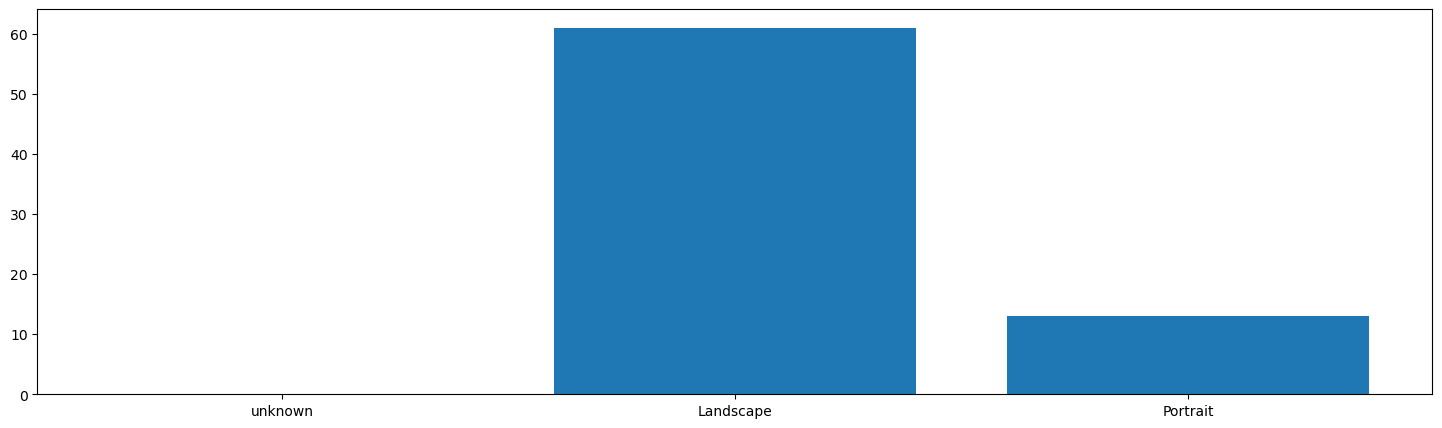

In [34]:
dataframe = getData()

criteriaToColumn = {'year':'dateTaken', 'orientation':'orientation'}
criteria = ''
while criteria not in criteriaToColumn :
    criteria = input('criteria (year ou orientation):')


categories = ['unknown']
cardinals  = [0]


for i in range(len(dataframe.index)):
    value = str(dataframe._get_value(i, criteriaToColumn[criteria]))

    if value != 'None':
        if criteria == 'year':
            value = value.split(':')[0].strip()
        elif criteria == 'orientation':
            value = {'0':"Portrait", '1':"Landscape"}[value]

        if value in categories:
            cardinals[categories.index(value)] += 1
        else:
            categories.append(value)
            cardinals.append(1)
    else:
        cardinals[0] += 1

f, ax = plt.subplots(figsize=(18,5))
plt.bar(categories, cardinals)

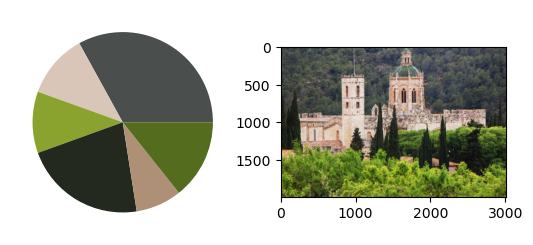

In [28]:
dataframe = getData()

imageIndex = randint(0, len(dataframe['label']))

fig, ax = plt.subplots(1,2)

ax[0].pie(dataframe.at[imageIndex,"dProportions"], colors=(numpy.array(dataframe.at[imageIndex, "dColors"])/255))
ax[1].imshow(PIL.Image.open(dataframe.at[imageIndex, "path"]))


## Application

In [33]:
wTab = ipywidgets.widgets.Tab()
currentUser = 'default'


# UsersWidget
wCurrentUser = ipywidgets.widgets.Dropdown(
    options=getUsers()['name'],
    value='default',
    description='Current User :',
    disabled=False
)
def updateCurrentUser(tmp):
    global currentUser
    currentUser = wCurrentUser.value
wCurrentUser.observe(updateCurrentUser)

def updateUserWidget():
    wCurrentUser.options = getUsers()['name']

# Create User Tab
wUsername = ipywidgets.widgets.Text(
    value='',
    placeholder='',
    description='Username:',
    disabled=False   
)
wBtnCreateUser = ipywidgets.widgets.Button(
    description='Create',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Creates a new user',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

def createUser(tmp):
    newUser = wUsername.value
    addUser(newUser)
    updateUserWidget()


wBtnCreateUser.on_click(createUser)

wBoxCreateUser = ipywidgets.HBox([wUsername,wBtnCreateUser])

# Random Images Tab
dataframe = getData()
imagePaths = []
imageIndexes = []

wBtnGetRnd = ipywidgets.widgets.Button(description="Get new random Images")
wBtnSelect = ipywidgets.widgets.Button(description="Validate Likes")



rowArray = [wBtnGetRnd]
wCheckArray = []
wImgLayout = ipywidgets.Layout(width = '60%')
cellLayout = ipywidgets.Layout(width = '50%', border = '3px')
def getRandomImages(tmp):
    global imagePaths
    imagePaths = []
    global imageIndexes
    imageIndexes = []
    global currentUser
    imageSeen = getUsers()['likes'][getUsers()["name"] == currentUser] + getUsers()['dislikes'][getUsers()["name"] == currentUser]
    for i in range(3):
        index = randint(0, len(dataframe.index)-1)
        while index in imageSeen or index in imageIndexes:
            index = randint(0, len(dataframe.index)-1)
        imagePaths.append(dataframe['path'][index])
        imageIndexes.append(index)
    cellArray = []

    global rowArray
    global wCheckArray

    rowArray = [wBtnGetRnd]
    wCheckArray = []

    for i,path in enumerate(imagePaths[:7]):
        with open(path, "rb") as f :
            wImg   = ipywidgets.widgets.Image(value=f.read(), layout = wImgLayout)
            wCheckArray.append(ipywidgets.Checkbox())
            cellArray.append(ipywidgets.HBox([wImg, wCheckArray[-1]], layout = cellLayout))
        if (i+1)%3 == 0:
            rowArray.append(ipywidgets.HBox(cellArray))
            cellArray = []
    rowArray.append(wBtnSelect)
    updateTab()

wBtnGetRnd.on_click(getRandomImages)


def get_likes(btn):
    likedImages    = [imageIndexes[i] for i, wCheck in enumerate(wCheckArray) if wCheck.value]
    dislikedImages = [index for index in imageIndexes if(index not in likedImages)]
    
    usersDf = getUsers()
    currentUserIndex = usersDf.index[usersDf['name'] == currentUser].tolist()[0]
    usersDf['likes'][currentUserIndex] += likedImages
    usersDf['dislikes'][currentUserIndex] += dislikedImages
    saveUsers(usersDf)
    print(usersDf)


wBtnSelect.on_click(get_likes)



# Recommandation Tab
wBtnReco = ipywidgets.widgets.Button(description="Get an recommandation")
wImg = ipywidgets.widgets.Image()
wBoxReco = ipywidgets.VBox([wBtnReco, wImg])
def getARecommandation(tmp):
    global wBoxReco
    global wBtnReco
    global wImg
    id = getRecommandation(currentUser)
    with open(dataframe['path'][id], "rb") as f :
        wImg = ipywidgets.widgets.Image(value=f.read(), layout = wImgLayout)
    wBoxReco = ipywidgets.VBox([wBtnReco, wImg])
    updateTab()
wBtnReco.on_click(getARecommandation)


def updateTab():
    global rowArray
    currentTab = wTab.selected_index
    wTab.children = [wBoxCreateUser, ipywidgets.VBox(rowArray), wBoxReco]
    wTab.titles   = ['User', 'Random Images', 'Recommandation']
    wTab.selected_index = currentTab

    return ipywidgets.VBox([wCurrentUser, wTab])


updateTab()

